# Pytorch

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## Dataset
---

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the data transformations
transform = transforms.Compose([
    #transforms.Resize((512, 512)),
    transforms.Resize((256, 256)),
    #transforms.Resize((28, 28)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load the image and label datasets
train_dataset = ImageFolder('train/images/', transform=transform)
label_dataset = ImageFolder('train/labels/', transform=transform)
test_dataset = ImageFolder('test', transform=transform)

# Combine the image and label datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dataset, label_dataset):
        self.image_dataset = image_dataset
        self.label_dataset = label_dataset
    
    def __getitem__(self, index):
        # Get the input and label images
        input_image, _ = self.image_dataset[index]
        label_image, _ = self.label_dataset[index]
        
        # Return the input and label images
        return input_image, label_image
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.image_dataset)

# Create a custom dataset
custom_dataset = CustomDataset(train_dataset, label_dataset)

# Create a data loader for the custom dataset
batch_size = 16
train_iter = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Model
---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

model = nn.Sequential(
    UNet(3, 3), 
)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 加载数据集并进行训练
epochs = 10
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_iter):
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # # 每4次迭代打印一次信息
        # if (i+1) % 4 == 0:
        #     
    #print(epoch, loss.item())
    print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.\
          format(epoch+1, epochs, i+1, len(train_iter), loss.item()))


## Train
---

In [ ]:
# 加载数据集并进行训练
epochs = 10
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_iter):
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # # 每4次迭代打印一次信息
        # if (i+1) % 4 == 0:
        #     
    #print(epoch, loss.item())
    print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.\
          format(epoch+1, epochs, i+1, len(train_iter), loss.item()))

In [ ]:
torch.save(model, 'model.pth')
# 定义字典，将模型、优化器和其他变量存储起来
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epochs,
    # 'loss': losses,
}

# 保存模型和优化器
torch.save(checkpoint, 'checkpoint.pth')

# 加载模型
model = torch.load('model.pth')

## Test
---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


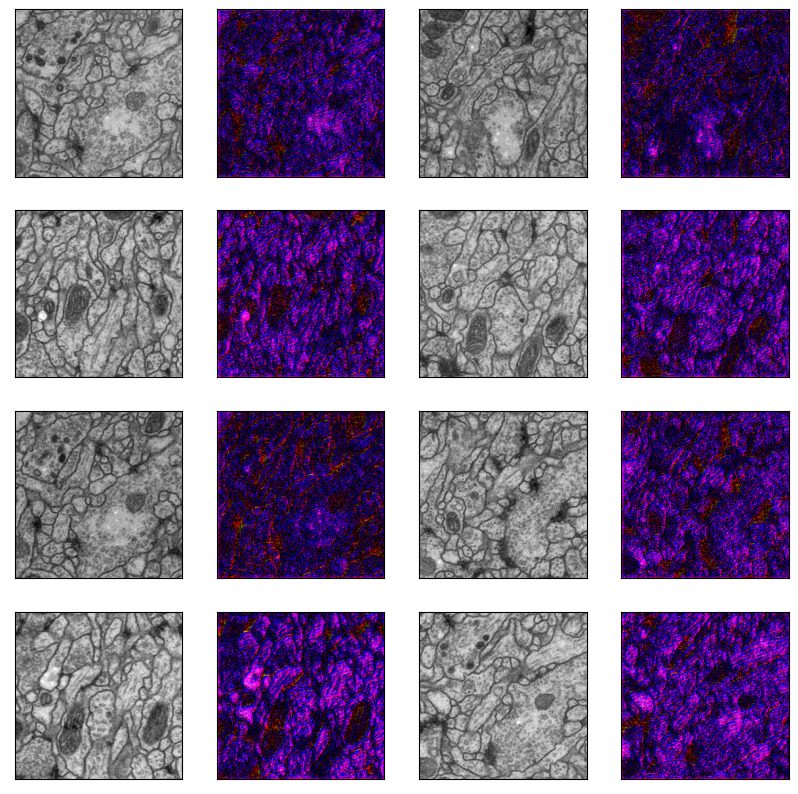

In [10]:
import matplotlib.pyplot as plt

X, y = next(iter(test_iter))
yy = model(X)

fig, ax = plt.subplots(figsize=(10, 10), nrows=4, ncols=4)
ax = ax.flatten()
for i in range(0, 16, 2):
    ax[i].imshow(X[i].permute(1, 2, 0))
    ax[i].axes.get_xaxis().set_visible(False) 
    ax[i].axes.get_yaxis().set_visible(False)
    # 将数据进行转置，使得通道维度在最后一个维度上
    ax[i+1].imshow(yy[i].permute(1, 2, 0).detach().numpy())
    ax[i+1].axes.get_xaxis().set_visible(False)
    ax[i+1].axes.get_yaxis().set_visible(False)


In [ ]:
import torchvision

# Test
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_iter = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 
                'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

         
j = 12

X, y = next(iter(test_iter))
XX = torch.cat((X[j], X[j], X[j]), dim=0)
y = XX.reshape(1, XX.shape[0], XX.shape[1], XX.shape[2])
y = torch.cat((y, y, y), dim=0)
yy = model(y)

fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=2)
ax = ax.flatten()
ax[0].imshow(X[j].reshape(X[j].shape[1], X[j].shape[2]).detach().numpy())
ax[1].imshow(yy[0][0].detach().numpy())

# Tensorflow

### Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

mnist = datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = tf.expand_dims(x_train, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)

x_test = tf.expand_dims(x_test, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

11490434/11490434 [==============================] - 1s 0us/step


In [8]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

from tensorflow.keras.utils import Sequence

def data_generator():
    path_images = './train/images/image/'
    path_labels = './train/labels/label/'

    files_images = os.listdir(path_images)
    files_images.sort()
    files_labels = os.listdir(path_labels)
    files_labels.sort()

    images = []
    labels = []
    for X, y in zip(files_images, files_labels):
        image = np.array(Image.open(path_images + X).convert('RGB'))
        label = np.array(Image.open(path_labels + y).convert('RGB'))
        images.append(image)
        labels.append(label)
    return images, labels

images, labels = data_generator()
images = tf.constant(images)
labels = tf.constant(labels)
images = tf.cast(images, tf.float32)
labels = tf.cast(labels, tf.float32)
images = images[:, ::4, ::4, :]/255.0
labels = labels[:, ::4, ::4, :]/255.0
# images = images/255.0
# labels = labels/255.0

batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(10000).batch(batch_size)


### CAE fig-fig Model

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv11 = Conv2D(32, 3, activation='relu', padding='same')
        self.conv12 = Conv2D(32, 3, activation='relu', padding='same')

        self.maxpool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv21 = Conv2D(64, 3, activation='relu', padding='same')
        self.conv22 = Conv2D(64, 3, activation='relu', padding='same')

        self.maxpool2 = tf.keras.layers.MaxPooling2D((2, 2)) 
        self.conv31 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv32 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv33 = Conv2D(128, 3, activation='relu', padding='same')

        self.up2 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat2 = tf.keras.layers.Concatenate(axis=3)
        self.convup21 = Conv2D(64, 3, activation='relu', padding='same')
        self.convup22 = Conv2D(64, 3, activation='relu', padding='same')

        self.up1 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat1 = tf.keras.layers.Concatenate(axis=3)
        self.convup11 = Conv2D(32, 3, activation='relu', padding='same')
        self.convup12 = Conv2D(32, 3, activation='relu', padding='same')

        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)
        self.s1 = tf.keras.layers.Softmax()

    def call(self, x):
        x = self.conv11(x)
        x = self.conv12(x)
        x1 = x      # 28x28x32

        x = self.maxpool1(x) # 14x14x32
        x = self.conv21(x)
        x = self.conv22(x)   # 14x14x64
        x2 = x

        x = self.maxpool2(x) # 7x7x64
        x = self.conv31(x)
        x = self.conv32(x)
        x = self.conv33(x)   # 7x7x128

        up2 = self.up2(x)    # 14x14x64
        x = self.concat2([x2, up2]) 
        x = self.convup21(x)   
        x = self.convup22(x)  

        up1 = self.up1(x)    # 28x28x32
        x = self.concat1([x1, up1])
        x = self.convup11(x)
        x = self.convup12(x) 
        
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.s1(x)
        return x

# Create an instance of the model
model = MyModel()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=50)

In [ ]:
i = 189

yy = model.predict(tf.expand_dims(x_test[i], axis=0))
yy[-1].argmax(), y_test[i], yy.shape

In [12]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, concatenate, UpSampling2D, MaxPooling2D


input = tf.keras.Input(shape=(128, 128, 3))
x = Conv2D(32, 3, activation='relu', padding='same')(input) 
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x1 = x      # 512x512x32
x = MaxPooling2D((2, 2))(x) # 256x256x32
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x2 = x      # 256x256x64
x = MaxPooling2D((2, 2))(x) # 128x128x64
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x3 = x      # 128x128x128
x = MaxPooling2D((2, 2))(x) # 64x64x128
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 128x128x256
x = concatenate([x3, x])    # 128x128x384
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 256x256x128
x = concatenate([x2, x])    # 256x256x192
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 512x512x64
x = concatenate([x1, x])    # 512x512x96
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = Conv2D(3, 3, activation='relu', padding='same')(x)
x = Conv2D(3, 1, activation='relu', padding='same')(x)

model = Model(inputs=input, outputs=x)


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D

class MyModel(Model):
    def __init__(self, input_shape):
        super(MyModel, self).__init__()
        self.conv11 = Conv2D(32, 3, activation='relu', padding='same')
        self.conv12 = Conv2D(32, 3, activation='relu', padding='same')

        self.maxpool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv21 = Conv2D(64, 3, activation='relu', padding='same')
        self.conv22 = Conv2D(64, 3, activation='relu', padding='same')

        self.maxpool2 = tf.keras.layers.MaxPooling2D((2, 2)) 
        self.conv31 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv32 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv33 = Conv2D(128, 3, activation='relu', padding='same')

        self.up2 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat2 = tf.keras.layers.Concatenate(axis=3)
        self.convup21 = Conv2D(64, 3, activation='relu', padding='same')
        self.convup22 = Conv2D(64, 3, activation='relu', padding='same')

        self.up1 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat1 = tf.keras.layers.Concatenate(axis=3)
        self.convup11 = Conv2D(32, 3, activation='relu', padding='same')
        self.convup12 = Conv2D(32, 3, activation='relu', padding='same')

        self.conva = Conv2D(3, 1, activation='relu', padding='same')


    def call(self, x):

        x = self.conv11(x)
        x = self.conv12(x)
        x1 = x      # 28x28x32

        x = self.maxpool1(x) # 14x14x32
        x = self.conv21(x)
        x = self.conv22(x)   # 14x14x64
        x2 = x

        x = self.maxpool2(x) # 7x7x64
        x = self.conv31(x)
        x = self.conv32(x)
        x = self.conv33(x)   # 7x7x128

        up2 = self.up2(x)    # 14x14x64
        x = self.concat2([x2, up2]) 
        x = self.convup21(x)   
        x = self.convup22(x)  

        up1 = self.up1(x)    # 28x28x32
        x = self.concat1([x1, up1])
        x = self.convup11(x)
        x = self.convup12(x) 

        x = self.conva(x)
        
        return x

# Create an instance of the model
inputs = tf.keras.Input(shape=(128, 128, 3))
model = MyModel(inputs)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(train_dataset, epochs=50)

### Train

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
#model.fit(train_dataset, epochs=500)
#model.save('unet_fig2fig_M1.h5')
model = tf.keras.models.load_model('unet_fig2fig.h5')

### Test

1/1 [==============================] - 0s 109ms/step


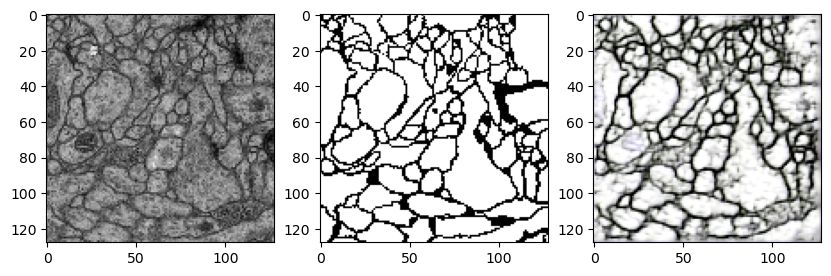

In [20]:
import matplotlib.pyplot as plt

X, y = next(iter(train_dataset))
i= 1

yy = model.predict(tf.expand_dims(X[i], axis=0))
yy.shape

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 10), nrows=1, ncols=3)
ax1.imshow(X[i])
ax2.imshow(y[i])
ax3.imshow(yy[0])

1/1 [==============================] - 0s 42ms/step


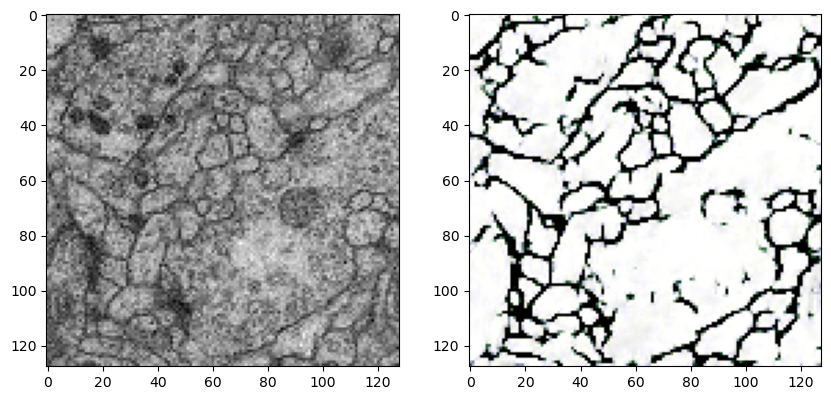

In [42]:
from PIL import Image
import numpy as np

files = os.listdir('./test/test/')
i = np.random.randint(0, len(files))


path = files[i]
image = np.array(Image.open('./test/test/'+path).convert('RGB'))
image = tf.constant(image)
image = tf.cast(image, tf.float32)
image = tf.expand_dims(image, axis=0)
image = image[:, ::4, ::4, :]/255.0

yy = model.predict(image)
fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), nrows=1, ncols=2)

ax1.imshow(image[0])
ax2.imshow(yy[0])


In [398]:
from scipy.interpolate import interp2d
import numpy as np

X, y = next(iter(dataset))

a = X[0].numpy()
x = np.linspace(0, 28, 28)
y = np.linspace(0, 28, 28)
# X, Y = np.meshgrid(x, y)


# x1 = np.arange(0, 128, 1)
# y1 = np.arange(0, 128, 1)
# X1, Y1 = np.meshgrid(x1, y1)

# f1 = interp2d(X, Y, a[:, :, 0], kind='cubic')
# Z1 = f1(X1, Y1)

x1 = np.linspace(0, 28, 128)
y1 = np.linspace(0, 28, 128)
f2 = interp2d(x, y, a[:, :, 0], kind='cubic')
Z2 = f2(x1, y1)


ZZ = np.expand_dims(Z2, axis=-1)
Z = np.concatenate((ZZ, ZZ, ZZ), axis=-1)
print(Z.shape)
yy = model.predict(tf.expand_dims(Z, axis=0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


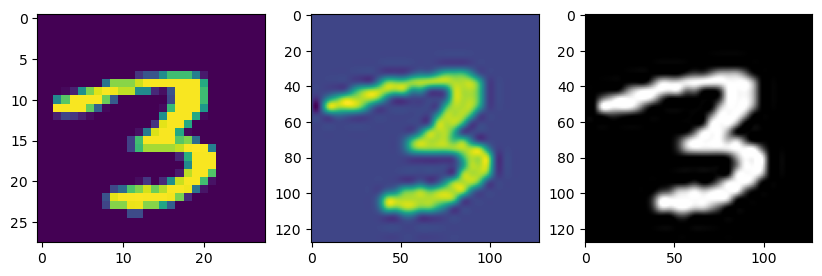

In [401]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 10), nrows=1, ncols=3)

ax1.imshow(a[:, :, 0])
ax2.imshow(ZZ)
ax3.imshow(Z)


In [356]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./ --host localhost